# Energy Reconstruction Using CNN

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from tensorflow.keras.callbacks import ModelCheckpoint

from data_tools import load_preprocessed, dataPrep, nameModel

## FIX THIS!
simPrefix = os.getcwd()+'\\simdata'

## Data Input

In [2]:
x, y = load_preprocessed(simPrefix, 'train')

Percentage of events with a NaN: 2.68


In [3]:
print(x.shape)
print(y.keys())
# each station has 2 tanks, each tank has 2 DOMs (high/log gain)
# each tank measures charge and time
# each station gives 2 charges and 2 times, 4 pieces of data
# x: (num, i, j, data)
# charge measured in VEM, vertical equivalent muon

# 'dir' is true direction, rest of dir are reconstructed by simulations
# plane assumes shower is flat plane
# laputop performs likelihood analysis
# small compromises between

(549773, 10, 10, 4)
dict_keys(['comp', 'energy', 'dir', 'plane_dir', 'laputop_dir', 'small_dir'])


In [3]:
# 85/15 split for training/testing
energy = y['energy']
comp = y['comp']
theta, phi = y['dir'].transpose()
nevents = len(energy)
randSel = np.random.uniform(size=nevents)
trainCut = randSel < 0.85
valCut = np.logical_not(trainCut)
energy.shape

(549773,)

(array([   52.,    80.,    83.,   129.,   159.,    92.,   187.,   211.,
          255.,   277.,   285.,   389.,   422.,   541.,   526.,   685.,
          787.,   954.,  1049.,  1249.,  1268.,  1463.,  1655.,  1750.,
         1908.,  2102.,  2711.,  3124.,  3324.,  3686.,  3949.,  3974.,
         4915.,  3387.,  3070.,  3232.,  3166.,  3634.,  3943.,  4178.,
         4551.,  4497.,  5040.,  5436.,  5441.,  5649.,  5659.,  6329.,
         6279.,  6820.,  6047.,  7009.,  8006.,  7950.,  8297.,  8436.,
         8520.,  8601.,  9076.,  9696.,  9830., 10713.,  9737., 10732.,
        12131., 10289.,  9602.,  4895.,  5198.,  5594.,  5596.,  6294.,
         5773.,  6021.,  6240.,  6311.,  6753.,  7024.,  7200.,  6564.,
         7888.,  6678.,  7667.,  8416.,  8197.,  8115.,  8535.,  8404.,
         9498.,  9570.,  8628., 10626., 10270., 10337., 10562., 10735.,
        11115., 11083., 12728., 12034.]),
 array([5.00020167, 5.03019956, 5.06019745, 5.09019534, 5.12019323,
        5.15019112, 5.1801

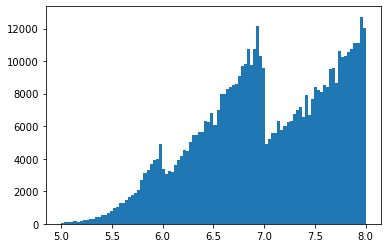

In [5]:
plt.hist(energy,bins=100)

In [4]:
print(x[...,0].flatten().shape)
print('Proportion of stations with Q1 != 0:',np.count_nonzero(x[...,0],axis=0,keepdims=True)/54977300)
print('Proportion of stations with Q1 != 0:',np.count_nonzero(x[...,0])/54977300)
print('Proportion of stations with Q2 != 0:',np.count_nonzero(x[...,1])/54977300)
print('Proportion of stations with Q1 and Q2 = 0:',np.count_nonzero(np.logical_and(x[...,0] == 0.0,x[...,1] == 0.0))/54977300)
print('Proportion of energy != 0:',np.count_nonzero(energy)/549773)

(54977300,)
Proportion of stations with Q1 != 0: [[[0.         0.         0.         0.         0.00250476 0.00285249
   0.00282678 0.00270814 0.0026237  0.00245259]
  [0.         0.         0.         0.00291728 0.00281578 0.00330051
   0.00339235 0.00302066 0.00328963 0.00239819]
  [0.         0.         0.00280283 0.00275603 0.00325654 0.00354888
   0.00321302 0.00343811 0.00313742 0.00188707]
  [0.         0.00265495 0.00301615 0.00325762 0.00302265 0.00281256
   0.00383427 0.00317162 0.00200712 0.00172391]
  [0.00237098 0.00283588 0.00334796 0.00310728 0.00306828 0.00343369
   0.00397992 0.00212375 0.00219074 0.00172175]
  [0.00238244 0.00288907 0.00317045 0.00291891 0.00257946 0.00246082
   0.0022942  0.00196303 0.00201309 0.00171082]
  [0.00263436 0.00289903 0.00287006 0.00284872 0.00237491 0.00236476
   0.00244266 0.00210705 0.00170838 0.        ]
  [0.00235705 0.00290192 0.00275294 0.00283981 0.00223687 0.00227541
   0.00200799 0.00184676 0.         0.        ]
  [0.00218748 0

(array([4.3753712e+07, 8.5081000e+05, 1.2861020e+06, 1.0464960e+06,
        8.7215200e+05, 8.1043600e+05, 8.8325000e+05, 8.3876500e+05,
        6.8673900e+05, 5.4230400e+05, 4.3348300e+05, 3.5975900e+05,
        3.0330200e+05, 2.5937200e+05, 2.2181900e+05, 1.9147700e+05,
        1.6777000e+05, 1.4623300e+05, 1.2814500e+05, 1.1295900e+05,
        1.0114600e+05, 9.1613000e+04, 8.2745000e+04, 7.5113000e+04,
        6.8428000e+04, 6.2669000e+04, 5.4995000e+04, 5.0141000e+04,
        4.2110000e+04, 3.7714000e+04, 3.6397000e+04, 3.3408000e+04,
        3.0618000e+04, 2.7442000e+04, 2.5191000e+04, 2.2881000e+04,
        2.1131000e+04, 1.9179000e+04, 1.7584000e+04, 1.6431000e+04,
        1.4722000e+04, 1.3546000e+04, 1.2269000e+04, 1.1295000e+04,
        1.0321000e+04, 9.1580000e+03, 8.2680000e+03, 7.4880000e+03,
        6.8450000e+03, 6.1850000e+03, 5.4370000e+03, 4.6140000e+03,
        3.7910000e+03, 2.6380000e+03, 1.8270000e+03, 1.1740000e+03,
        1.0560000e+03, 1.1030000e+03, 1.0270000e

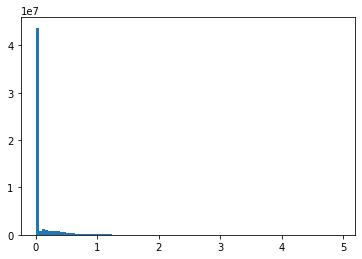

In [6]:
plt.hist(x[...,0].flatten(),bins=100)

(array([4.679900e+04, 9.267980e+05, 1.272329e+06, 1.031748e+06,
        8.627780e+05, 8.122870e+05, 8.854100e+05, 8.299280e+05,
        6.768300e+05, 5.340170e+05, 4.278650e+05, 3.557000e+05,
        3.002300e+05, 2.568020e+05, 2.198980e+05, 1.894770e+05,
        1.665970e+05, 1.449760e+05, 1.270010e+05, 1.121250e+05,
        1.005980e+05, 9.095800e+04, 8.238500e+04, 7.456400e+04,
        6.811300e+04, 6.238000e+04, 5.453600e+04, 4.986000e+04,
        4.170200e+04, 3.766900e+04, 3.617100e+04, 3.328200e+04,
        3.042000e+04, 2.726300e+04, 2.513800e+04, 2.278100e+04,
        2.100100e+04, 1.908500e+04, 1.756200e+04, 1.632900e+04,
        1.463400e+04, 1.348900e+04, 1.223200e+04, 1.127200e+04,
        1.024600e+04, 9.125000e+03, 8.229000e+03, 7.466000e+03,
        6.804000e+03, 6.168000e+03, 5.394000e+03, 4.635000e+03,
        3.714000e+03, 2.589000e+03, 1.818000e+03, 1.163000e+03,
        1.048000e+03, 1.098000e+03, 1.034000e+03, 1.157000e+03,
        1.294000e+03, 1.350000e+03, 1.62

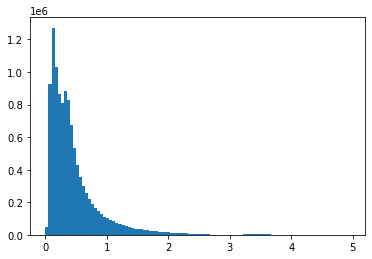

In [44]:
plt.hist(x[x[...,0]!=0.0,0].flatten(),bins=100)

(array([5.493000e+04, 9.872150e+05, 1.290617e+06, 1.038011e+06,
        8.632230e+05, 8.052650e+05, 8.822760e+05, 8.311710e+05,
        6.820680e+05, 5.395110e+05, 4.318090e+05, 3.568630e+05,
        3.025000e+05, 2.587980e+05, 2.215320e+05, 1.924280e+05,
        1.675230e+05, 1.472540e+05, 1.284860e+05, 1.139070e+05,
        1.014040e+05, 9.167500e+04, 8.395600e+04, 7.559700e+04,
        6.995800e+04, 6.322200e+04, 5.594300e+04, 4.924500e+04,
        4.287600e+04, 3.836300e+04, 3.620600e+04, 3.380800e+04,
        3.102600e+04, 2.809400e+04, 2.567900e+04, 2.294000e+04,
        2.117300e+04, 1.946800e+04, 1.789000e+04, 1.651800e+04,
        1.506900e+04, 1.373700e+04, 1.261200e+04, 1.144700e+04,
        1.055500e+04, 9.355000e+03, 8.511000e+03, 7.710000e+03,
        6.929000e+03, 6.343000e+03, 5.529000e+03, 4.802000e+03,
        3.893000e+03, 2.670000e+03, 1.770000e+03, 1.324000e+03,
        1.067000e+03, 1.094000e+03, 1.140000e+03, 1.234000e+03,
        1.314000e+03, 1.426000e+03, 1.64

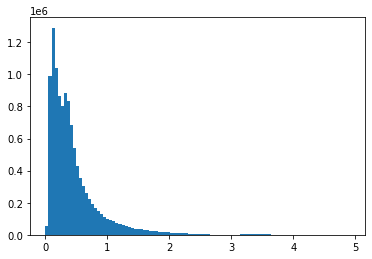

In [20]:
plt.hist(x[x[...,1]!=0.0,1].flatten(),bins=100)

(array([1.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 2.000000e+00, 0.000000e+00, 2.000000e+00,
        1.000000e+00, 2.000000e+00, 3.000000e+00, 7.000000e+00,
        9.000000e+00, 5.000000e+00, 1.200000e+01, 1.700000e+01,
        1.700000e+01, 2.400000e+01, 2.600000e+01, 4.500000e+01,
        4.600000e+01, 6.800000e+01, 9.200000e+01, 9.800000e+01,
        1.420000e+02, 1.810000e+02, 2.540000e+02, 3.320000e+02,
        5.060000e+02, 7.460000e+02, 1.028000e+03, 1.408000e+03,
        2.119000e+03, 3.111000e+03, 4.508000e+03, 6.552000e+03,
        1.083000e+04, 1.787800e+04, 3.033000e+04, 5.156300e+04,
        8.790900e+04, 1.539200e+05, 2.739970e+05, 4.699120e+05,
        6.741690e+05, 7.223700e+05, 8.535380e+05, 1.143214e+06,
        1.548389e+06, 1.120093e+06, 8.899380e+05, 1.249249e+06,
        1.540529e+06, 1.111499e+06, 8.339620e+05, 7.251180e+05,
        6.616020e+05, 4.482000e+05, 2.604220e+05, 1.461240e+05,
        8.377700e+04, 4.962700e+04, 2.93

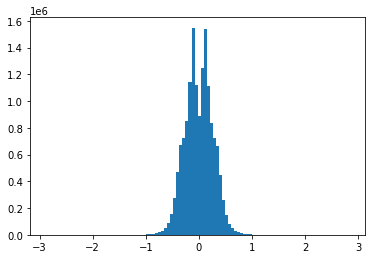

In [24]:
notBothZero = np.invert(np.logical_and(x[...,0] == 0.0,x[...,1] == 0.0))
plt.hist(x[notBothZero,1].flatten()-x[notBothZero,0].flatten(),bins=100)

## Model Training

### Alpha Model
- Input: no charge merge, no time layers included, normalized data
- Layers: Two convolutional
- Output: Energy

In [ ]:
# Name for model
key = 'first_model'

# Data preparation: no merging of charge (q), no time layers included (t=False), data normalized from 0-1
prep = {'q':None, 't':False, 'normed':True}

In [ ]:
# Create model
model = Sequential(name=nameModel(prep, 'test'))  # Automatic naming for flexible assessment later
# Add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(10,10,2)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1)) # No activation function for last layer of regression model

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])

In [ ]:
# Establish arrays to be trained on
x_i = dataPrep(x, y, **prep)
temp_y = energy

In [ ]:
# Train
history = model.fit(x_i[trainCut], temp_y[trainCut], validation_data=(x_i[valCut], temp_y[valCut]), epochs=3)

In [ ]:
# Save model to file for easy loading
## WHERE ARE YOU SAVING TO?
model.save('model_%s.h5' % key)
model.evaluate(x_i[testCut], temp_y[testCut])

## Your task

- **Create your own model**
- Replace the model here w/ *simplified* form of Brandon's model (focus: including zenith)
- change the zenith input to cosine(zenith) input

In [ ]:
history.history